# About this Notebook

There are always a lot of great kernels regarding different ways of solving the problems but only a few handful address the problems of domain knowledge and getting started.

In this notebook, we will start with the explanation of everything related to Prostate Cancer and its detection and we will built on that to explain the dataset, perform EDA and then Build a baseline model.

# Domain Knowledge
So lets start with the domain knowledge and address the first question

### Q1) What is Prostate Cancer?
Prostate cancer is cancer that occurs in the prostate, a small walnut-shaped gland in men that produces the seminal fluid that nourishes and transports sperm.

Prostate cancer is one of the most common types of cancer in men. Usually prostate cancer grows slowly and is initially confined to the prostate gland, where it may not cause serious harm. However, while some types of prostate cancer grow slowly and may need minimal or even no treatment, other types are aggressive and can spread quickly.

<img src="https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/38/ds00043_-my01633_im01561_prostca1thu_jpg.jpg" height="100px">

### Q2) How it is tested and detected?
Prostate screening tests might include:

* Digital rectal exam (DRE): During a DRE, your doctor inserts a gloved, lubricated finger into your rectum to examine your prostate, which is adjacent to the rectum. If your doctor finds any abnormalities in the texture, shape or size of the gland, you may need further tests.
* Prostate-specific antigen (PSA) test: A blood sample is drawn from a vein in your arm and analyzed for PSA, a substance that's naturally produced by your prostate gland. It's normal for a small amount of PSA to be in your bloodstream. However, if a higher than normal level is found, it may indicate prostate infection, inflammation, enlargement or cancer.

If a DRE or PSA test detects an abnormality, your doctor may recommend further tests to determine whether you have prostate cancer, such as:

* Ultrasound : If other tests raise concerns, your doctor may use transrectal ultrasound to further evaluate your prostate. A small probe, about the size and shape of a cigar, is inserted into your rectum. The probe uses sound waves to create a picture of your prostate gland.
* Collecting a sample of prostate tissue : If initial test results suggest prostate cancer, your doctor may recommend a procedure to collect a sample of cells from your prostate (prostate biopsy). Prostate biopsy is often done using a thin needle that's inserted into the prostate to collect tissue. The tissue sample is analyzed in a lab to determine whether cancer cells are present.

### Q3) Where does GLEASON score fit-in all of this?
When a biopsy confirms the presence of cancer, the next step is to determine the level of aggressiveness (grade) of the cancer cells. A laboratory pathologist examines a sample of your cancer to determine how much cancer cells differ from the healthy cells. A higher grade indicates a more aggressive cancer that is more likely to spread quickly.

The most common scale used to evaluate the grade of prostate cancer cells is called a Gleason score. Gleason scoring combines two numbers and can range from 2 (nonaggressive cancer) to 10 (very aggressive cancer), though the lower part of the range isn't used as often.

### Q4) What is GLEASON score? 
Please watch the video below

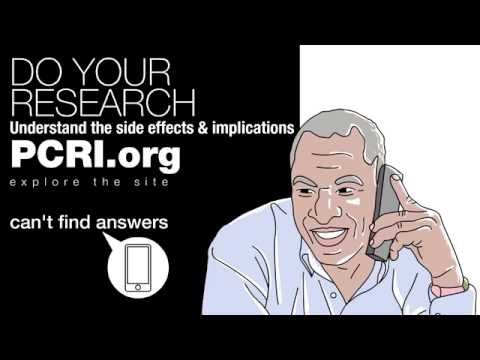

In [1]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('UuG__lpn8qQ',width=600, height=400)

### Q5) I got it but What is ISUP grade now?
According to current guidelines by the International Society of Urological Pathology (ISUP), the Gleason scores are summarized into an ISUP grade on a scale from 1 to 5 according to the following rule:

* Gleason score 6 = ISUP grade 1 
* Gleason score 7 (3 + 4) = ISUP grade 2 
* Gleason score 7 (4 + 3) = ISUP grade 3 
* Gleason score 8 = ISUP grade 4 
* Gleason score 9-10 = ISUP grade 5 

If there is no cancer in the sample, we use the label ISUP grade 0 in this competition. 

<img src="https://storage.googleapis.com/kaggle-media/competitions/PANDA/Screen%20Shot%202020-04-08%20at%202.03.53%20PM.png" height="100px">

### Q6) How has the Gleason scores been generated in the dataset?
Each WSI in this challenge contains one, or in some cases two, thin tissue sections cut from a single biopsy sample. Prior to scanning, the tissue is stained with haematoxylin & eosin (H&E). This is a standard way of staining the originally transparent tissue to produce some contrast. The samples are made up of glandular tissue and connective tissue. The glands are hollow structures, which can be seen as white “holes” or branched cavities in the WSI. The appearance of the glands forms the basis of the Gleason grading system. The glandular structure characteristic of healthy prostate tissue is progressively lost with increasing grade. The grading system recognizes three categories: 3, 4, and 5. 

* [A] Benign prostate glands with folded epithelium :The cytoplasm is pale and the nuclei small and regular. The glands are grouped together.
* [B] Prostatic adenocarcinoma : Gleason Pattern 3 has no loss of glandular differentiation. Small glands infiltrate between benign glands. The cytoplasm is often dark and the nuclei enlarged with dark chromatin and some prominent nucleoli. Each epithelial unit is separate and has a lumen.
* [C] Prostatic adenocarcinoma : Gleason Pattern 4 has partial loss of glandular differentiation. There is an attempt to form lumina but the tumor fails to form complete, well-developed glands. This microphotograph shows irregular cribriform cancer, i.e. epithelial sheets with multiple lumina. There are also some poorly formed small glands and some fused glands. All of these are included in Gleason Pattern 4.
* [D] Prostatic adenocarcinoma : Gleason Pattern 5 has an almost complete loss of glandular differentiation. Dispersed single cancer cells are seen in the stroma. Gleason Pattern 5 may also contain solid sheets or strands of cancer cells. All microphotographs show hematoxylin and eosin stains at 20x lens magnification.

<img src="https://storage.googleapis.com/kaggle-media/competitions/PANDA/GleasonPattern_4squares%20copy500.png" height="100px">

# References

* https://www.kaggle.com/code/quadeer15sh/transfer-learning-how-to-perform-finetuning/notebook
* https://www.kaggle.com/code/tanulsingh077/prostate-cancer-in-depth-understanding-eda-model

In [2]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px

plt.rcParams['font.size'] =  12

# Transfer Learning: Finetuning

- Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. - Generic Wiki Definition
- The early convolutional layers in a CNN extract generic features and become more specific to the training data as we go deeper into the network.
- Due to this behaviour of CNNs we can choose a level of extracting features for a given problem statement.
- An example of transfer learning can be seen in the image below where the final classification layer of the network is changed and is kept as the only trainable layer in the network leveraging the weights of the network previously trained

<img src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/04/13204041/1.png" height="400" width="800">

- Choosing the appropriate level for transfer learning is dependent on two important factors
    - **Size of the dataset:** Small or Large ?
    - **Similarity of Domain:** Source and Target datasets Same or Different?
- The factors state above lead to the following four combination of scenarios
    1. Target dataset is **small and similar** to the source dataset
    2. Target dataset is **small but different** than the source dataset
    3. Target dataset is **large and similar** to the source dataset
    4. Target dataset is **large but different** than the source dataset

In [3]:
# Define data path
BASE_DIR = '/kaggle/input/prostate-cancer-classification-ukm/Prostate_Split/'
train_dir = BASE_DIR + "Train/"
test_dir = BASE_DIR + "Test/"

# Determining the Size of the Dataset
- Determine whether to regard the dataset as small or large by analysing the number of image samples per class

In [4]:
training_data = []
test_data = []
labels = os.listdir(train_dir)
for folder in os.listdir(train_dir):
    training_data.append(len(os.listdir(os.path.join(train_dir,folder))))
    
for folder in os.listdir(test_dir):
    test_data.append(len(os.listdir(os.path.join(test_dir,folder))))

In [5]:
fig = px.bar(x=labels, y=training_data, title='Class Count Training Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [6]:
fig = px.bar(x=labels, y=test_data, title='Class Count Test Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

**Inference:** 
- There are around 30 image samples per class in the training set 
- However, a large dataset contains at least 5000-10000 image samples per class
- So we will regard this as a small dataset

# Data Generator

In [7]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(train_dir,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    subset='validation',
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 132 images belonging to 4 classes.
Found 21 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


# Determining the Similarity of Domain
- We need to find out how similar are the images of our dataset to the ones of Imagenet-1000 on which the complex architectures have been built

## Prostate Images Dataset Samples

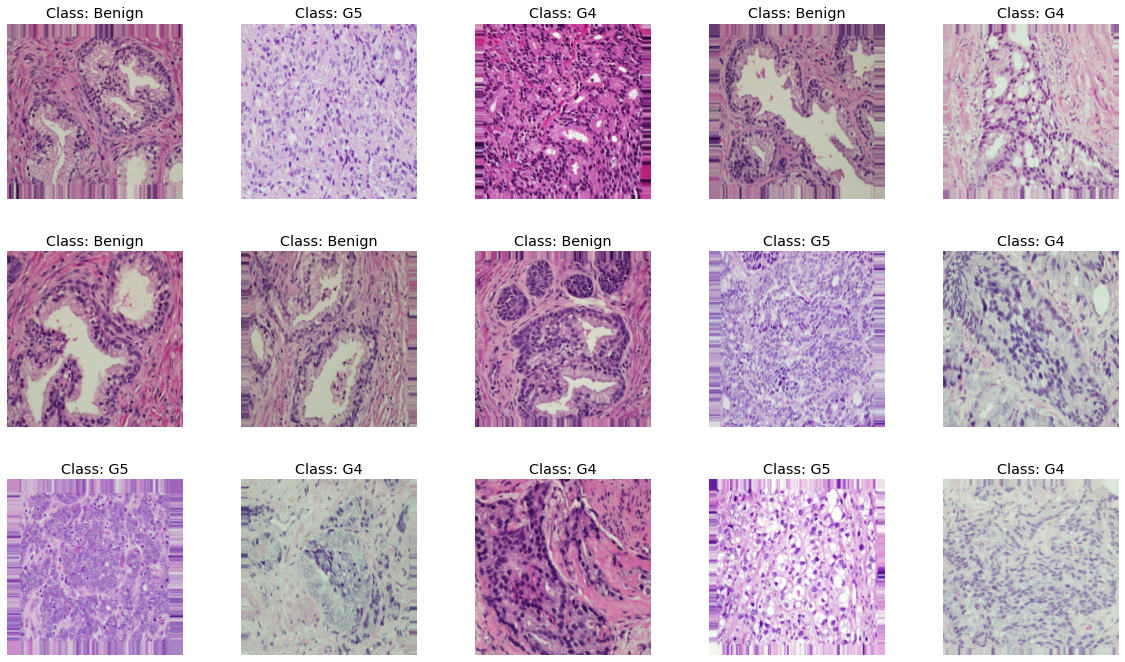

In [8]:
labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

## ImageNet Images Dataset Samples

<img src="https://devopedia.org/images/article/172/7316.1561043304.png" height="400" width="800">

- The full list of classes of the Imagenet Dataset can be found on this link: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
- After going through the list of classes I found that there were labels like - church buildings, seashores, street, etc but no concrete label resembling to the image labels we want to train the network on
- **Conclusion:** The domain of the dataset is different

# Finetuning Approach

| Size of the target dataset | Similarity of target and source dataset | Approach |
| --- | --- | --- |
| Small | Similar | Use the pretrained network for feature extraction and train the last layer for classification, or you can train a separate ML model to train on the extracted features |
| Large | Similar | Freeze approximately 60-80% of the pretrained network and retrain the weights of the layers of the remaining part of the network |
| Small | Different | Since the dataset is different it might not be good idea to freeze the higher level layers which capture features specific to the image dataset. We also cannot finetune through the entire network as the target dataset is small which might lead to overfitting. Therefore freeze first third or half of the pretrained network so that they capture the low level features like edges, colors, etc. and retrain the remaining part of the network **(Our Case)** |
| Large | Different | Since the target dataset is large and the domain is different a good idea would be to leverage the weight initialization of the pretrained network, as this will help your model converge faster, and retrain the entire network on your target dataset |

# DenseNet-201 Finetuning
- You can experiment with various pretrained networks, the above rules will be applicable to all of them
- A good understanding of the network architectures will play an important role in finetuning
- We have chosen DenseNet201 just out of personal choice, but feel free to experiment with other networks as well

## DenseNet Illustration

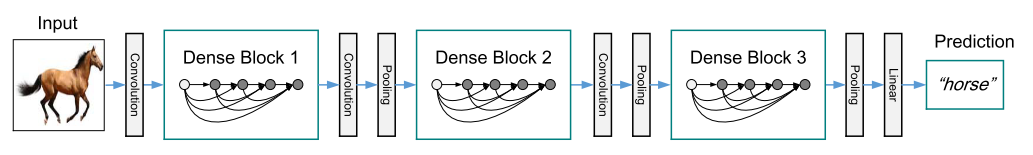

In [9]:
img_size = 224
base_model = DenseNet201(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

2023-01-08 12:08:13.854325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:13.855229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:13.859770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:13.860611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:13.861379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

74850304/74836368 [==============================] - 0s 0us/step


## DenseNet201 Reference

<img src="https://imgur.com/oiTdqJL.jpg">

In [10]:
print(len(base_model.layers))

707


In [11]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Freeze the Lower layers
- Since we have a small dataset with a different dataset domain than the source we will freeze 1/3rd of the architecture
- For DenseNet-201, I have used my knowledge about the architecture and have frozen the first two Dense Blocks of the network

In [12]:
freeze_index = None
for i,layer in enumerate(base_model.layers):
    if 'conv4' in layer._name:
        freeze_index = i
        break
        
for layer in base_model.layers[:freeze_index]:
    layer.trainable = False

## New Model Head
- Add more dense layers to the pretrained architecture suiting the needs of the problem in hand
- An important step here is to **keep the learning rate low** so that the weights learnt during finetuning are not very different than the strong feature extracting weights learnt by the pretrained network on the Imagenet Dataset 

In [13]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Training Callbacks
- Checkpoint the model with the best validation loss
- Stop the training earlier than the set epochs if the validation loss does not decrease after 5 continous epochs
- Reduce the learning rate by 30% if the validation loss does not decrease after 3 continous epochs

In [14]:
model_name = "prostate_model_densenet.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [15]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

2023-01-08 12:08:25.488347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-08 12:08:44.502000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 62s 8s/step - loss: 1.2886 - accuracy: 0.4318 - val_loss: 1.1617 - val_accuracy: 0.4762

Epoch 00001: val_loss improved from inf to 1.16168, saving model to prostate_model_densenet.h5
Epoch 2/15
5/5 [==============================] - 8s 2s/step - loss: 0.5989 - accuracy: 0.8106 - val_loss: 0.9681 - val_accuracy: 0.6190

Epoch 00002: val_loss improved from 1.16168 to 0.96808, saving model to prostate_model_densenet.h5
Epoch 3/15
5/5 [==============================] - 8s 1s/step - loss: 0.3445 - accuracy: 0.8864 - val_loss: 0.8930 - val_accuracy: 0.6190

Epoch 00003: val_loss improved from 0.96808 to 0.89303, saving model to prostate_model_densenet.h5
Epoch 4/15
5/5 [==============================] - 7s 1s/step - loss: 0.2416 - accuracy: 0.9621 - val_loss: 0.8261 - val_accuracy: 0.6667

Epoch 00004: val_loss improved from 0.89303 to 0.82607, saving model to prostate_model_densenet.h5
Epoch 5/15
5/5 [==============================] - 8s 2s/step - los

In [16]:
loss_test, acc_test = model.evaluate(test_generator)
loss_val, acc_val = model.evaluate(validation_generator)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1/1 [==============================] - 1s 781ms/step - loss: 0.6883 - accuracy: 0.8095
Validation: accuracy = 0.809524  ;  loss_v = 0.688269
Test: accuracy = 0.750000  ;  loss = 0.730585


# Learning Curves
- If you ever see your learning curves in this manner, believe me you wouldn't want to deploy your model
- Something seems to be affecting our model which is causing it to overfit, lets look into the problem through classification metrics

## Loss Curve

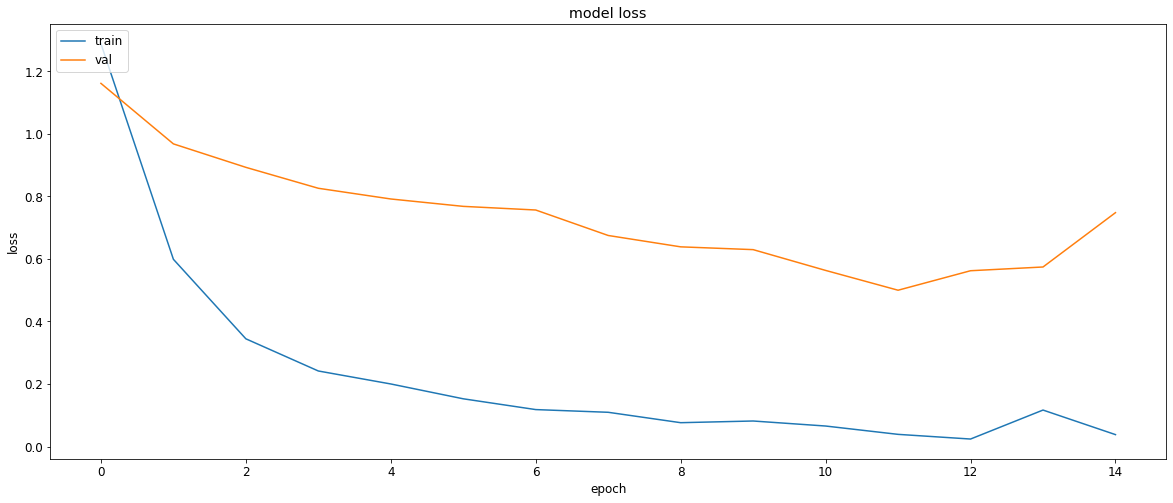

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Accuracy Curve

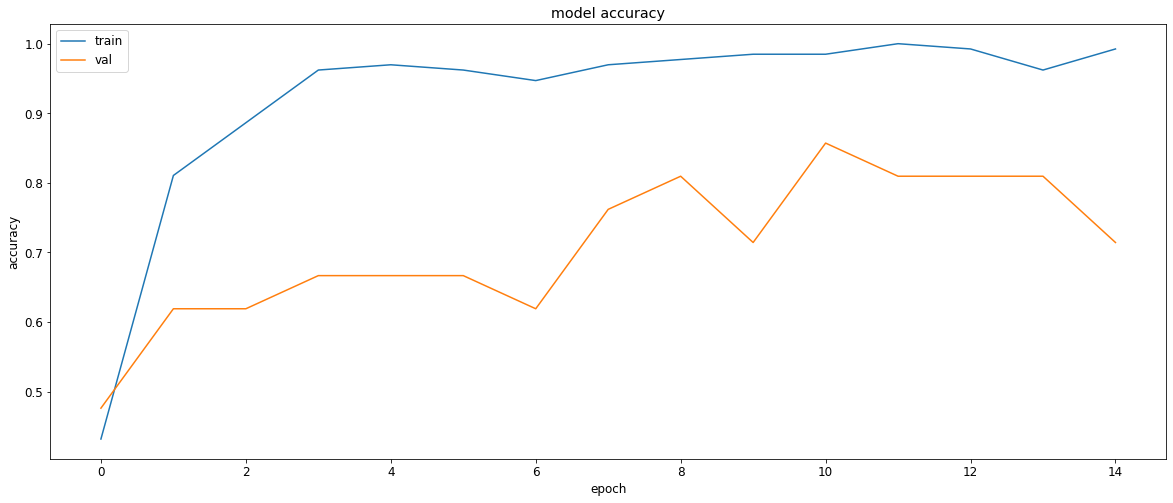

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
y_test = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

## Classification Report
- From the classification metrics we can clearly see that the main problem is with the G3 and Benign class, which is a bit reasonable as the small collection of images might have confused the model between the two
- Same goes for G3 and G5 next
- Lets look at the Confusion Matrix to confirm our suspicions about what is getting misclassified into what

# Evaluation Metrics

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

      Benign       0.91      1.00      0.95        10
          G3       0.56      0.90      0.69        10
          G4       1.00      0.10      0.18        10
          G5       0.83      1.00      0.91        10

    accuracy                           0.75        40
   macro avg       0.83      0.75      0.68        40
weighted avg       0.83      0.75      0.68        40



## Confusion Matrix
- Our suspicions were correct, G3 and Benign are getting misclassified into each other
- Similar is the case with G3 and G5
- One can add more data to avoid this conflict
- Or several image augmentation techniques can be experimented with, however since the scope of this notebook is restricted to Finetuning of pretrained models I will not be covering that

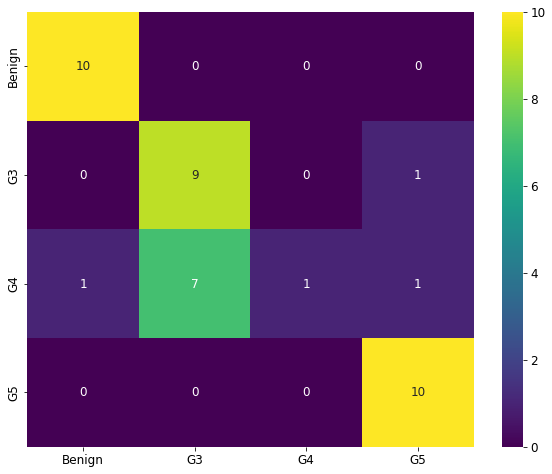

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()